# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.8 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
import os
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


In [6]:
print("Each Agent's state shape is "+str(states[0].shape)+", where each stack has 8 number")
print("Agent1")
print("Stack1"+str(states[0][0:8]))
print("Stack2"+str(states[0][8:16]))
print("Stack3"+str(states[0][16:24]))
print("================")
print("Agent2")
print("Stack1"+str(states[1][0:8]))
print("Stack2"+str(states[1][8:16]))
print("Stack3"+str(states[1][16:24]))
print("================")
print ("thus, state_size is "+ str(state_size))

Each Agent's state shape is (24,), where each stack has 8 number
Agent1
Stack1[ 0.  0.  0.  0.  0.  0.  0.  0.]
Stack2[ 0.  0.  0.  0.  0.  0.  0.  0.]
Stack3[-6.65278625 -1.5        -0.          0.          6.83172083  6.         -0.
  0.        ]
Agent2
Stack1[ 0.  0.  0.  0.  0.  0.  0.  0.]
Stack2[ 0.  0.  0.  0.  0.  0.  0.  0.]
Stack3[-6.4669857  -1.5         0.          0.         -6.83172083  6.          0.
  0.        ]
thus, state_size is 24


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [7]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291


In [8]:
from utilities import transpose_list, transpose_to_tensor
from workspace_utils import keep_awake
!pip install progressbar

  Running setup.py bdist_wheel for progressbar ... done
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built progressbar


### 4. Description of the Learning Algorithm
---

So the Learnning Algo. is based on :

* Deep Deterministic Gradient Policy (DDGP)
* Noise for randomness to explore more 
* Noise Decay to expliot more as number of epsiodes grow 
* An underlying NNs (defined later below)
* Imporvments used to enhance the Deep DDPQ such as :
 * Replay Buffer
 * Fixed Targets
 
A sinlge DDPG agent, where it does self-play. ie play one time for agent1 of the enviroment , and another for agent2 of the enviroment. That is sharing the weights of Actor-Critics NN.

The DDPG Critic's for now observes a single agent observation and not both. Same for the Actor, acts only on the agent's single observation.

#### 4.1 First lets Explore the Agent¶


Each agent will have the following 
1. Hyper-Parameters:
 * batch size: 		 1000000
 * buffer size: 		 1000000
 * discount / gamma: 	   0.990
 * actor learning rate: 	   0.001
 * critic learning rate: 	   0.001
 * soft update / tau: 	   0.001
 * noise decay rate: 	   0.999
 
 
2.As DDGP Neural Networks:
 * Actor Local NN :
     * input (state 24 input vector)
     * output (continous actions values for the 4 actions)
 * Actor Target NN:
     * input (state 24 input vector)
     * output (continous actions values for the 4 actions) with fixed target
 * Critic local NN:
     * input (state 24 input vector, 2 input action )
     * output (single continous output) the critics' estimate of the current (state,action) pair 
 * Cirtic Target NN:
     * input (state 24 input vector, 2 input action )
     * output (1 continous value) the critics' estimate of the current (state,action) pair with fixed target 
 * Hidden layers of 400 followed by 300
 * Batch Normalization on the first hidden layer.
 * 2nd Batch Normalization on the second layer on the Critic.

In [9]:
from ddpg_agent import Agent as DDPG_Agent
agent= DDPG_Agent(state_size=state_size, action_size=action_size, random_seed=10)

DDPG Agent hyperparameters:
	batch size: 		 1000000
	buffer size: 		 1000000
	discount / gamma: 	   0.990
	actor learning rate: 	   0.001
	critic learning rate: 	   0.001
	soft update / tau: 	   0.001
	noise decay rate: 	   0.999
	
Actor network built: ModuleList(
  (0): Linear(in_features=24, out_features=400, bias=True)
  (1): Linear(in_features=400, out_features=300, bias=True)
  (2): Linear(in_features=300, out_features=2, bias=True)
)
Actor network built: ModuleList(
  (0): Linear(in_features=24, out_features=400, bias=True)
  (1): Linear(in_features=400, out_features=300, bias=True)
  (2): Linear(in_features=300, out_features=2, bias=True)
)
Critic network built: ModuleList(
  (0): Linear(in_features=24, out_features=400, bias=True)
  (1): Linear(in_features=402, out_features=300, bias=True)
  (2): Linear(in_features=300, out_features=1, bias=True)
)
Critic network built: ModuleList(
  (0): Linear(in_features=24, out_features=400, bias=True)
  (1): Linear(in_features=402, out_fea

### 5. Trainning 2 Agents Env with a single DDGP  (small taste of MADDGP)
---
In order to Solve this environment, the maximum reward gained by the 2 agents achieving an average reward (over 100 episodes) of at least 0.5
   
In order not to waste testing time, the below trainning function breaks upon achieving the solve criteria and prints out Enviroment Solved. However, it is possible that function might return without achieving the criteria.


In [15]:


def MADDGP(env,number_of_episodes= 4000,SuccessCriteria = 0.50):

    # training loop
    # show progressbar
    import progressbar as pb
    widget = ['episode: ', pb.Counter(),'/',str(number_of_episodes),' ',
              pb.Percentage(), ' ', pb.ETA(), ' ', pb.Bar(marker=pb.RotatingMarker()), ' ' ]

    #timer = pb.ProgressBar(widgets=widget, maxval=number_of_episodes).start()

    #init scores
    scores = []
    average_score =[]
    agent_scores = []
    top_score = -10.0
    
    # use keep_awake to keep workspace from disconnecting
    for episode in keep_awake(range(0, number_of_episodes, 1)):

#         timer.update(episode)
        state = env.reset(train_mode=True)[brain_name].vector_observations
        agent.noise.reset()
        scores_per_episode = np.zeros(num_agents)

        while True:
            action = agent.act(state)
            env_info = env.step(action)[brain_name]

            reward = env_info.rewards
            next_state = env_info.vector_observations
            done = env_info.local_done

            agent.step(state[0], action[0], reward[0], next_state[0], done[0])
            agent.step(state[1], action[1], reward[1], next_state[1], done[1])


            state = next_state
            scores_per_episode += reward

            if any(env_info.local_done):
                break
        
        #Update scores
        scores.append(scores_per_episode.max())
        average_score.append(np.mean(scores[-100:]))
        agent_scores.append(scores_per_episode)
        
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f} \tAgent1 {} \tAgent2 {}'.format(episode, average_score[-1].mean(),  scores[-1],scores_per_episode[0],scores_per_episode[1]))

        if np.mean(scores) > top_score:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            top_score = np.mean(scores)


        if  average_score[-1].mean() >= SuccessCriteria:
            print('\nEnvironment solved in {:d} episodes\tAverage Score: {:.2f}'.format(episode, average_score[-1].mean()))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
#     timer.finish()
    return scores ,average_score , agent_scores

scores, average_score, agent_scores = MADDGP(env,number_of_episodes=5000)

    

Episode 0	Average Score: 0.00	Score: 0.00 	Agent1 0.0 	Agent2 -0.009999999776482582
Episode 1	Average Score: 0.00	Score: 0.00 	Agent1 -0.009999999776482582 	Agent2 0.0
Episode 2	Average Score: 0.03	Score: 0.10 	Agent1 0.09000000171363354 	Agent2 0.10000000149011612
Episode 3	Average Score: 0.03	Score: 0.00 	Agent1 0.0 	Agent2 -0.009999999776482582
Episode 4	Average Score: 0.02	Score: 0.00 	Agent1 -0.009999999776482582 	Agent2 0.0
Episode 5	Average Score: 0.02	Score: 0.00 	Agent1 -0.009999999776482582 	Agent2 0.0
Episode 6	Average Score: 0.01	Score: 0.00 	Agent1 0.0 	Agent2 -0.009999999776482582
Episode 7	Average Score: 0.01	Score: 0.00 	Agent1 0.0 	Agent2 -0.009999999776482582
Episode 8	Average Score: 0.01	Score: 0.00 	Agent1 -0.009999999776482582 	Agent2 0.0
Episode 9	Average Score: 0.02	Score: 0.10 	Agent1 0.10000000149011612 	Agent2 -0.009999999776482582
Episode 10	Average Score: 0.03	Score: 0.10 	Agent1 -0.009999999776482582 	Agent2 0.10000000149011612
Episode 11	Average Score: 0.0

### 6. Results
---
Below is graph Heighting:

* The Avg of the max rewards of the 2 agents' rewards for each Eposide, blue line.

* The Min score required , orange line, at score 0.5 to show relatively the perfomance of the agent against the 1st success criteria, ie the minScore

* The Avg Achieved Score, green Line, on the last 100 Episodes which is the 2nd success criteria, ie the MinEposides

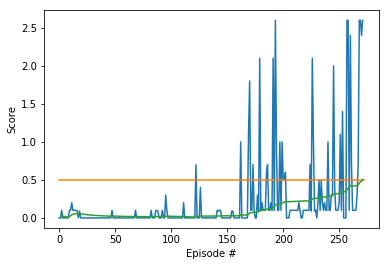

In [59]:
# scores, average_score, agent_scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores) #scores
plt.plot([0,len(scores)], [0.5,0.5]) # Criteria Min Value
plt.plot(np.arange(len(scores)), average_score) #Avg scores

plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 7. Ideas for Future Work
---

So there is few points that I can tackle on further work:

1. Trying the less Arch as 24 input vector may require less complex architure. :
    * Different layers
    * different neurons / layer
    * Different activations
    * Drophouts
    * Optimizers, etc


2. Searching for best Hyper-parameters mentioned above: 
    * Smaller learning rate
    * Larger UPDATE_EVERY, etc
    * Noise meterics, (mu,theta, sigma)


3. Trying The 2nd Version of 20 Agents where it is applicable to apply different algos :
    * PPO
    * A3C
    * D4PG.


4. Changing the input from the enviroment space and shifiting to pixels


5. MOST importantly , I intended to extend the the 2 agents' observations to the critic instead of a single agent's obervation. 

When finished, you can close the environment.

In [ ]:
env.close()